# This notebook details an analysis of Defensive all team nominations and defensive statistics.

## At the end of each NBA season, 2 Defensive all teams are voted by the media. 1st team contains the best 2 guard defenders and best 3 front-court defenders. 2nd team contains the following 2 best guard defenders and following 3 front-court defenders

## This notebook investigates the correlation between different defensive statistics and nomination to an All-Defensive Team

In [1]:
from pandas import read_html
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from bs4 import BeautifulSoup
import urllib.request
import numpy as np
import scipy.stats as scipy
import Defensive_Stats as stats
import Defense_All_Team as all_teams
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Data-Preprocessing

All data is either pulled from stats.nba.com or basketballreference.com 

<br>
Data processing and engineering is done in both __Defense_all_team.py__ and __Defense_General.py__

In [2]:
First_Team,Second_Team = all_teams.get_all_defense()

In [3]:
First_Team.head()
#First_Team.to_csv("First_Team.csv")
#Second_Team.to_csv("Second_Team.csv")

,Player,Year,All_Team
0,Kawhi Leonard,2016.0,1
1,Patrick Beverley,2016.0,1
2,Chris Paul,2016.0,1
3,Draymond Green,2016.0,1
4,Rudy Gobert,2016.0,1


Concatenate the two defensive teams for ease of analysis and visualization

In [4]:
Both_Teams = First_Team.append(Second_Team)

Import the rest of the data

In [5]:
Defense_General = stats.Defense_General()
Shooting = stats.Shooting()

In [6]:
#Player_info = stats.player_stats()
Player_info = pd.read_csv("Player_info.csv")

Create DataFrame containing player positions. 

<br>
This is done because comparing between positions may allow for better analysis.

In [7]:
Positions = Player_info.loc[:,['Year','Player','Pos']]
Positions['Year'] = Positions['Year'].astype(float)

Remove the asterisk that exists for some players from the data pulled from basketballreference.com

In [8]:
def asterisk (name):
    if "*" in name:
        return name[:(len(name)-1)]
    else:
        return name

In [9]:
Positions['Player'] = Positions['Player'].apply(asterisk)

Perform an outer join between Defense_General, Shooting DataFrames and Position DataFrame. 

<br>
Null values will represent those players that were not voted into either team. Fill the null values with 0's

In [10]:
Defense_General = pd.merge(Defense_General,Both_Teams, on = ['Year','Player'],how = 'outer')
Defense_General = pd.merge(Defense_General,Positions, on = ['Year','Player'])
Defense_General['All_Team'] = Defense_General['All_Team'].fillna(0)
#Defense_General.to_csv("Defense_General.csv")

In [11]:
Shooting = pd.merge(Shooting,Both_Teams, on = ['Year','Player'],how = 'outer')
Shooting = pd.merge(Shooting,Positions, on = ['Year','Player'])
Shooting['All_Team'] = Shooting['All_Team'].fillna(0)
#Shooting.to_csv("Shooting.csv")

In [12]:
Shooting = pd.merge(Shooting,Defense_General[['Year','Player','MIN','DEF_RATING']], on = ['Year','Player'])

Split the DataFrames into its various positions and remove any possible duplicates.

In [13]:
PG_Defense = Defense_General[Defense_General['Pos'].str.contains("PG")]
SG_Defense = Defense_General[Defense_General['Pos'].str.contains("SG")]
SF_Defense = Defense_General[Defense_General['Pos'].str.contains("SF")]
PF_Defense = Defense_General[Defense_General['Pos'].str.contains("PF")]
C_Defense = Defense_General[Defense_General['Pos'].str.contains("C")]

In [14]:
G_Defense = Defense_General[Defense_General['Pos'].str.contains("G")]
F_Defense = Defense_General[Defense_General['Pos'].str.contains("F")]

In [15]:
PG_Defense.drop_duplicates(inplace=True)
SG_Defense.drop_duplicates(inplace=True)
SF_Defense.drop_duplicates(inplace=True)
PF_Defense.drop_duplicates(inplace=True)
C_Defense.drop_duplicates(inplace=True)
G_Defense.drop_duplicates(inplace=True)
F_Defense.drop_duplicates(inplace=True)

## Analysis

Looking at the data, there are certain features that might be identified as useless fields in the table.

For example, fields like __Player_ID__, __Team name__ and __Player name__ can all be dropped.

<br>
sklearns Logistic Regression's coefficient array will be used to as a first check for the correlation between features and defensive team nomination. The coefficients may obviously be skewed due to the smaller sample size (20 years)

<br>
Also, ranks are chosen over the raw values because different years may cause statistics to be inflated or deflated.

In [16]:
X_all = Defense_General.loc[:,"GP_RANK":"DEF_WS_RANK"]
Y_all = Defense_General['All_Team']

In [17]:
logistic_model = LogisticRegression()
logistic_model.fit(X_all,Y_all)
coeff_df = DataFrame(list(zip(X_all.columns, np.transpose(logistic_model.coef_)[:,0],
                              np.transpose(logistic_model.coef_)[:,1], np.transpose(logistic_model.coef_)[:,2])),
                     columns = ['Feature','No Nomination','First Team','Second Team'])

In [18]:
coeff_df.sort_values(by = "First Team" , ascending = True)

,Feature,No Nomination,First Team,Second Team
4,MIN_RANK,0.017977,-0.026500,-0.008731
12,PCT_BLK_RANK,0.016558,-0.015254,-0.012242
3,W_PCT_RANK,0.007926,-0.013306,-0.003028
10,PCT_STL_RANK,0.013081,-0.012523,-0.008416
8,PCT_DREB_RANK,0.011713,-0.010124,-0.014912
5,DEF_RATING_RANK,0.008201,-0.010089,0.001107
1,W_RANK,0.008219,-0.004664,-0.010569
0,GP_RANK,-0.000868,-0.001069,0.003880
15,OPP_PTS_FB_RANK,-0.001280,-0.000553,0.002092
17,DEF_WS_RANK,0.010455,-0.000197,-0.027566


In [19]:
coeff_df.sort_values(by = "Second Team" , ascending = True).head(10)

,Feature,No Nomination,First Team,Second Team
17,DEF_WS_RANK,0.010455,-0.000197,-0.027566
8,PCT_DREB_RANK,0.011713,-0.010124,-0.014912
12,PCT_BLK_RANK,0.016558,-0.015254,-0.012242
1,W_RANK,0.008219,-0.004664,-0.010569
4,MIN_RANK,0.017977,-0.026500,-0.008731
10,PCT_STL_RANK,0.013081,-0.012523,-0.008416
6,DREB_RANK,0.001462,0.001194,-0.008123
3,W_PCT_RANK,0.007926,-0.013306,-0.003028
13,OPP_PTS_OFF_TOV_RANK,-0.001939,0.003292,-0.001939
16,OPP_PTS_PAINT_RANK,-0.003827,0.005053,-0.001410


In [20]:
coeff_df.sort_values(by = "No Nomination" , ascending = True).head(10)

,Feature,No Nomination,First Team,Second Team
7,DREB_PCT_RANK,-0.012626,0.006282,0.022586
9,STL_RANK,-0.011973,0.010994,0.007879
11,BLK_RANK,-0.010527,0.013128,0.004527
14,OPP_PTS_2ND_CHANCE_RANK,-0.004569,0.002762,0.001448
16,OPP_PTS_PAINT_RANK,-0.003827,0.005053,-0.001410
2,L_RANK,-0.003007,0.002233,0.005094
13,OPP_PTS_OFF_TOV_RANK,-0.001939,0.003292,-0.001939
15,OPP_PTS_FB_RANK,-0.001280,-0.000553,0.002092
0,GP_RANK,-0.000868,-0.001069,0.003880
6,DREB_RANK,0.001462,0.001194,-0.008123


From the tables above, a few features are standing out to be good indicators for the three categories of players:

<br>
For both __first and second team__, features such as __minutes__, __win percentage__, __games played__ and __defensive win shares__ seem to be the indicators for which players will be nominated into the defensive all team


For __non-nominees__, features like 

__Losses__

__Opponent 2nd Chance points__ (Meaning points scored after the opponent gets an offensive rebound)

__Opponent Points in the Paint__

__Blocks__

__Steals rank__ 

seem like good indicators

For the indicators for defensive team players, the features seem to make sense: 

<br>
Players who play more games and win more games are often more recognized by the media.

However, for non-nominees, it would seem like features such as __2nd Chance Points__ or __Opponent Points in the paint__ would also determine a player's defensive prowess.

Before moving forward, it might be interesting to see how defensive all team nominations in general compare with the rest of the league.

In [21]:
def all_team(team):
    if team > 0:
        return 1
    else:
        return 0

In [22]:
Merged = Defense_General.copy()
Merged['All_Team']= Merged['All_Team'].apply(all_team)

In [23]:
Merged_X = Merged.loc[:,"GP_RANK":"DEF_WS_RANK"]
Merged_Y = Merged['All_Team']

In [24]:
logistic_model1 = LogisticRegression()
logistic_model1.fit(Merged_X,Merged_Y)
coeff_df1 = DataFrame(list(zip(X_all.columns, np.transpose(logistic_model.coef_)[:,0])),
                     columns = ['Feature','Correlation'])

In [25]:
coeff_df1['Correlation_Absolute']= coeff_df1['Correlation'].astype(float).abs()
coeff_df1.sort_values(by= "Correlation_Absolute",ascending = False)

,Feature,Correlation,Correlation_Absolute
4,MIN_RANK,0.017977,0.017977
12,PCT_BLK_RANK,0.016558,0.016558
10,PCT_STL_RANK,0.013081,0.013081
7,DREB_PCT_RANK,-0.012626,0.012626
9,STL_RANK,-0.011973,0.011973
8,PCT_DREB_RANK,0.011713,0.011713
11,BLK_RANK,-0.010527,0.010527
17,DEF_WS_RANK,0.010455,0.010455
1,W_RANK,0.008219,0.008219
5,DEF_RATING_RANK,0.008201,0.008201


Interestingly, __Defensive Rating__ only seems like an average indicator for both teams.

### Investigating opponent points scored metrics

The following four graphs plot the __minutes_rank__ versus the 4 opponent shooting metrics 

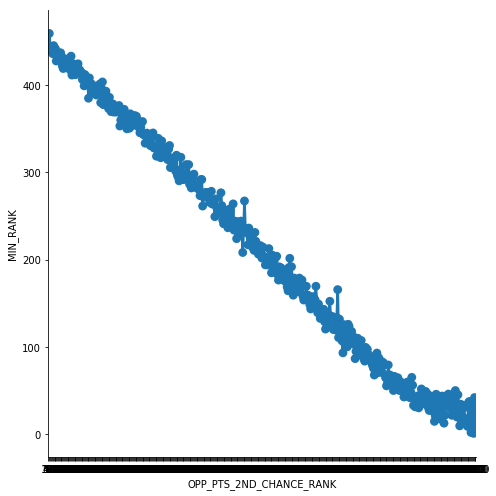

In [26]:
sns.factorplot(x="OPP_PTS_2ND_CHANCE_RANK",y="MIN_RANK",data = Defense_General,ci=0,size=7)

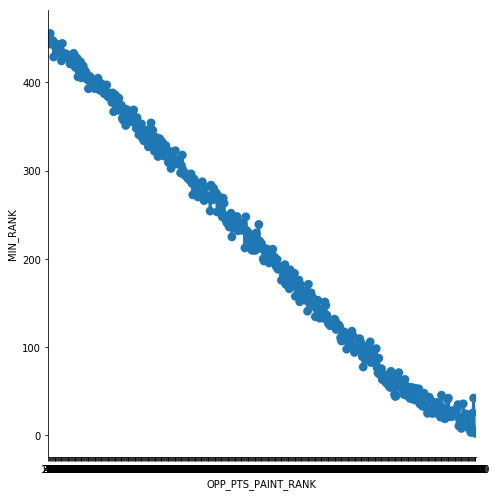

In [27]:
sns.factorplot(x="OPP_PTS_PAINT_RANK",y="MIN_RANK",data = Defense_General,ci=0,size=7)

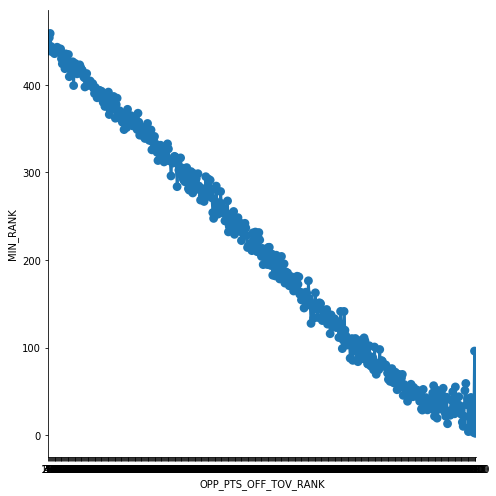

In [28]:
sns.factorplot(x="OPP_PTS_OFF_TOV_RANK",y="MIN_RANK",data = Defense_General,ci=0,size=7)

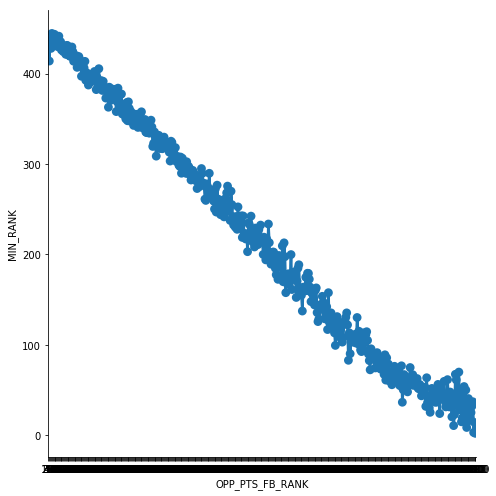

In [29]:
sns.factorplot(x="OPP_PTS_FB_RANK",y="MIN_RANK",data = Defense_General,ci=0,size=7)

The correlation between the opponent scoring statistics and minutes played can be seen very clearly.

<br>
Perhaps because all team defensive players play more minutes than non nominated players on average, they will let up more points on average in all these situations. 

<br>
A better way to analyze this is perhaps to find the points let up in each situation per minute, to negate the difference in the volume of minutes 

In [30]:
Defense_General['OPP_PTS_OFF_TOV_RANK/MIN'] = Defense_General['OPP_PTS_OFF_TOV_RANK']/Defense_General['MIN']
Defense_General['OPP_PTS_2ND_CHANCE_RANK/MIN'] = Defense_General['OPP_PTS_2ND_CHANCE_RANK']/Defense_General['MIN']
Defense_General['OPP_PTS_FB_RANK/MIN'] = Defense_General['OPP_PTS_FB_RANK']/Defense_General['MIN']
Defense_General['OPP_PTS_PAINT_RANK/MIN'] = Defense_General['OPP_PTS_PAINT_RANK']/Defense_General['MIN']

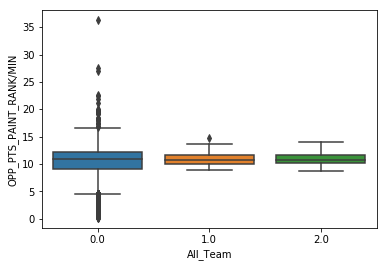

In [31]:
sns.boxplot(x="All_Team",y="OPP_PTS_PAINT_RANK/MIN",data = Defense_General)

After adjusting for minutes played, the stats still seem to lack any indication as to who will make the defensive all teams. 

<br>
One other possible explanation for this is that they level of competition is normally higher as they would be playing opposing team starters

### Position specific indicators

In the preliminary analysis, it seems that steal and blocks are not truly indicative of nominated players.

<br>
This may seem counter-intuitive, but this may perhaps be because steals and blocks are important for different positions. For example, when was the last time a guard appeared top-10 in the blocks list?

<br>
The following two graphs plots the steals rank for guards over the years and the blocks rank for centers over the years

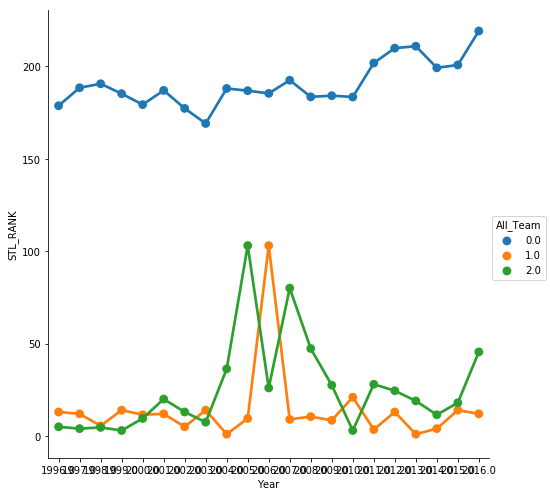

In [32]:
sns.factorplot(x="Year",y="STL_RANK",data = G_Defense,hue="All_Team",ci=0,size=7)

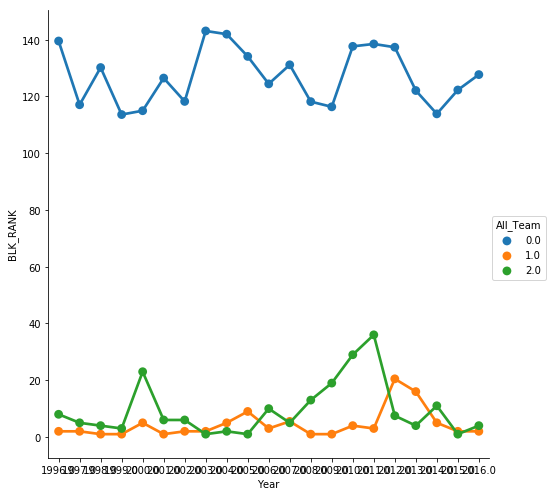

In [33]:
sns.factorplot(x="Year",y="BLK_RANK",data = C_Defense,hue="All_Team",ci=0,size=7)

As expected, guards who rank the highest in steals are nominated into the defensive teams, while bigs who rank the highest in blocks are nominated in the defensive teams.

## Case of John Wall's 2016 Season

In the 2016-2017 season, John Wall led the league in steals at 157 (2 steals /Game), he however got left off from the either all defensive teams. Whether he got snubbed is a personal opinion, but most people think that because he led the league in steals, he should have been nominated.

Using a Chi-Squared test, its possible to validate whether or not this opinion is well informed or not.

>Null Hypothesis: Players who lead the league are not necessarily in a Defensive Team (Independent)

>Alternative Hypothesis: Players who lead the league in steals should be in a Defensive team


In [34]:
Steals_df = stats.steals_df()
Steals_df['Player'] = Steals_df['Player'].apply(asterisk)
Steals_df = pd.merge(Steals_df,Positions, on = ['Year','Player'])
Steals_df = pd.merge(Steals_df,Both_Teams, on = ['Year','Player'],how = 'left')
Steals_df = Steals_df.fillna(0) #drop 2017
Steals_df

,Year,Player,Steals,Team,Pos,All_Team
0,2016.0,John Wall,157,WAS,PG,0.0
1,2015.0,Stephen Curry,169,GSW,PG,0.0
2,2014.0,Stephen Curry,163,GSW,PG,0.0
3,2013.0,Ricky Rubio,191,MIN,PG,0.0
4,2012.0,Mike Conley,174,MEM,PG,2.0
5,2011.0,Chris Paul,152,LAC,PG,1.0
6,2010.0,Chris Paul,188,NOH,PG,2.0
7,2009.0,Rajon Rondo,189,BOS,PG,1.0
8,2008.0,Chris Paul,216,NOH,PG,1.0
9,2007.0,Chris Paul,217,NOH,PG,2.0


In [35]:
print("Number of Non Nominated players who have led the league in steals are: " + str(len(Steals_df[Steals_df["All_Team"]==0])))

Number of Non Nominated players who have led the league in steals are: 22


In [36]:
print("Number of first team players who have led the league in steals are: " + str(len(Steals_df[Steals_df["All_Team"]==1])))

Number of first team players who have led the league in steals are: 4


In [37]:
print("Number of second team players who have led the league in steals are: " + str(len(Steals_df[Steals_df["All_Team"]==2])))

Number of second team players who have led the league in steals are: 6


In [38]:
print("Number of Non Nominated players who have led the league in steals are : "+ str(len(Positions[Positions["Year"] != 2017])))

Number of Non Nominated players who have led the league in steals are : 17407


In [39]:
print("Number of First and Second Team players are: " + str(((1+2016-1985)*5)+2)) #5 players per year except 2 ties for each team

Number of First and Second Team players are: 162


Table of observations:

![Title](Chi-Square.png)

Table of expected frequencies:

![Title](Chi-Square2.png)

The total for the chi-Squared statistic is calculated to be 156.1478. 

Doing the p value calcuations with a degrees of freedom of 2, the p-value is <0.00001. With any significance level, the null hypothesis will be failed because the p-value is very small. Clearly, there is a clear dependence between leading the league in steals and getting into a first or second team defense.

__Null hypothesis failed__

Therefore, John Wall's feeling of getting snubbed is seems to be well justified.


Other more advanced statistics will be explored in place of simple stat counting numbers in the rest of this workbook.

## Investigation of Minutes

One of the first features of the common indicators between first team and second team nominations appear to be minutes played. Therefore, its important to confirm the correlation.

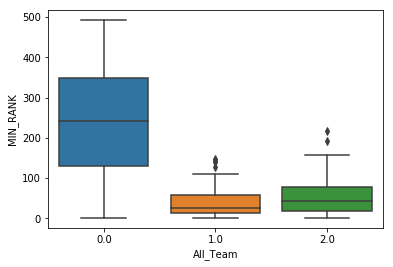

In [40]:
sns.boxplot(x="All_Team",y="MIN_RANK",data = Defense_General)

The fact that
> 1) There is a huge distribution between non defensive team nominees

> 2) There is a small distribution between First and Second team Defensive players

is not surprising at all. The reason is that there a much larger sample size for non-nominees, and obviously there are plenty of starters in the league that do not get nominated. Similarly, players need to play over a certain threshold in order for them to be recognized by the media as good defensive players.

In [41]:
First_Team_MIN = Defense_General['MIN'][Defense_General['All_Team']==1]
Second_Team_MIN = Defense_General['MIN'][Defense_General['All_Team']==2]
Non_Nominees_MIN = Defense_General['MIN'][Defense_General['All_Team']==0]

In [42]:
SD_and_Mean_MIN = DataFrame(data = [First_Team_MIN.std(),Second_Team_MIN.std(),Non_Nominees_MIN.std()]
                               ,columns = ["S.D"])
SD_and_Mean_MIN['All_Team'] = list([1,2,3])
SD_and_Mean_MIN['Mean'] = list([First_Team_MIN.mean(),Second_Team_MIN.mean(),Non_Nominees_MIN.mean()])
SD_and_Mean_MIN

,S.D,All_Team,Mean
0,3.508392,1,36.146429
1,3.892715,2,34.712727
2,9.867731,3,19.731481


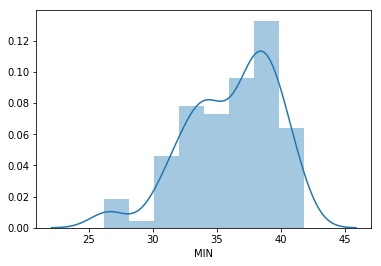

In [43]:
sns.distplot(First_Team_MIN)

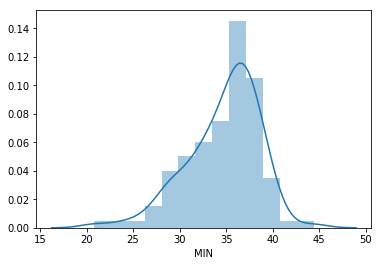

In [44]:
sns.distplot(Second_Team_MIN)

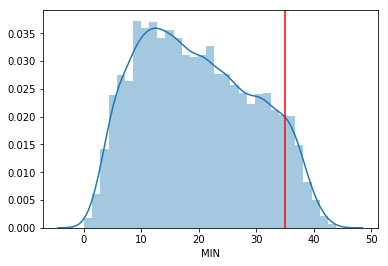

In [45]:
sns.distplot(Non_Nominees_MIN)
plt.axvline(x=35,color ="r")

__The mean for defensive rating for both teams is approximately 35.__

By approximating the distribution to a normal distribution for non_nominees, the probability that a non-nominee falls above 35 (1.54 standard deviations out) is approximately __6% of the time.__.

This seems more reasonable, as explained before.

Although this may not seem like a useful metric to analyse, but may aid future analysis.

## Investigation of Defensive Rating

Looking at the Defensive Rating feature for different positions might be a good way to see why it appears it is not that strong of an indicator

Defensive Rating is simply __the number of points per 100 possessions a player gives up__

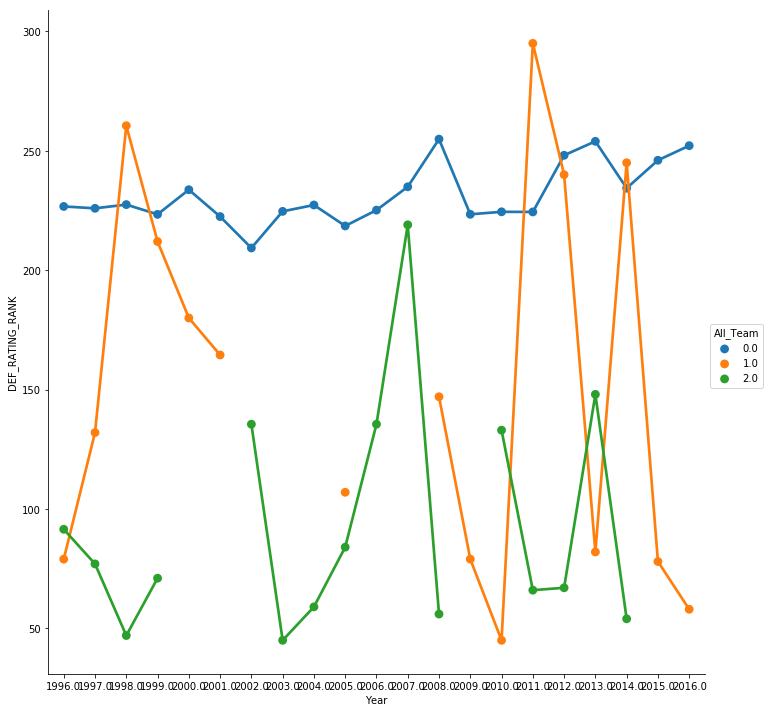

In [46]:
sns.factorplot(x="Year",y="DEF_RATING_RANK",data = PG_Defense,hue="All_Team",ci=0,size=10)

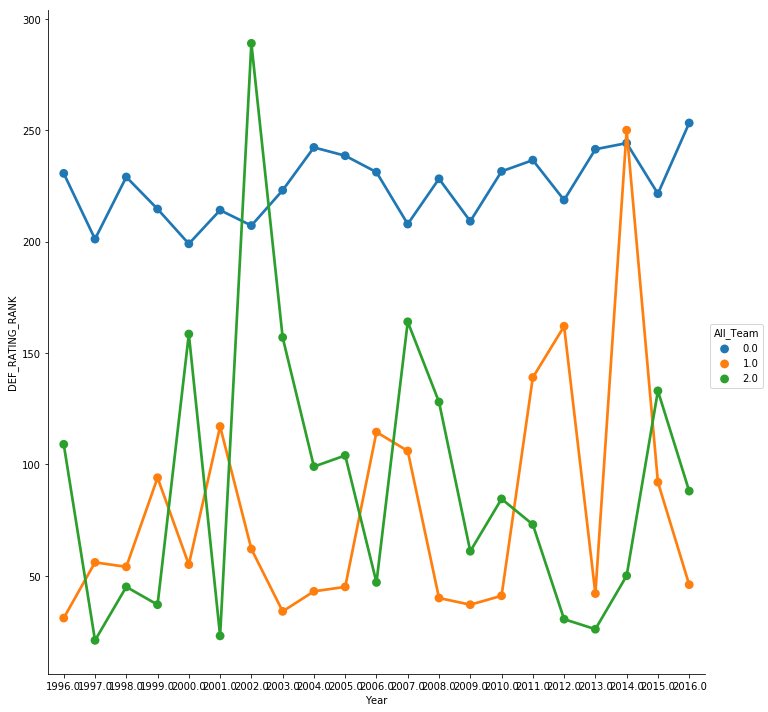

In [47]:
sns.factorplot(x="Year",y="DEF_RATING_RANK",data = C_Defense,hue="All_Team",ci=0,size=10)

It seems that Point Guards' defensive rating is not as correlated to their nomination as Centers'. Two possible reasons are that:

>1. There are not as many PG's nominated, so the sample size is skewed
>2. Defensive impact of bigs are more than points guards, which affects the defensive rating

In [48]:
Second_Team[Second_Team['Year']==2002]

,Player,Year,All_Team
71,Metta World Peace,2002.0,2
72,Bruce Bowen,2002.0,2
73,Jason Kidd,2002.0,2
74,Shaquille O'Neal,2002.0,2
75,Eric Snow,2002.0,2


There are outliers for both positions in terms of Defensive Ratings, but less exist for the bigs. 

The one big spike at 2002 for the centers is Shaq. The Lakers that season had a DefRtg of 104.7, good for 19th in the league.
This is a possible explanation for this outlier, as Shaq might have been dominant despite the Lakers being ranked poorly in Defensive Rating.

Let's explore the distributions of Defensive Rating for the various teams to get a better idea of any patterns that exist for this feature.

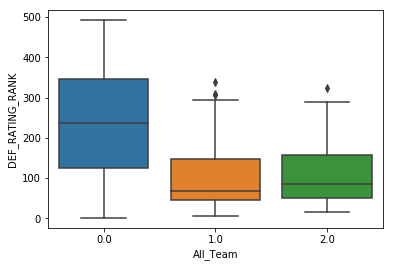

In [49]:
sns.boxplot(x = "All_Team", y = "DEF_RATING_RANK", data = Defense_General)

From the boxplot, there seems to be a lot of players that rank highly in defensive rating, but do not get nominated to any defensive team. 

<br>
Let's check out the players who rank highly over the years but do not get nominated.

In [50]:
Non_nominees_DEFR = Defense_General[Defense_General['All_Team'] == 0]
Non_nominees_DEFR = Non_nominees_DEFR.loc[:,["Player","DEF_RATING_RANK","Year","DEF_RATING","MIN","Pos"]]
Non_nominees_DEFR.sort_values(by = "DEF_RATING_RANK", ascending = True).head(30)

,Player,DEF_RATING_RANK,Year,DEF_RATING,MIN,Pos
9377,Dexter Pittman,1.0,2013.0,66.7,1.5,C
4529,Maurice Baker,1.0,2004.0,66.6,3.8,PG
3464,Paul Shirley,1.0,2002.0,25.4,2.9,PF
11110,Danuel House,1.0,2016.0,0.0,0.8,SG
4530,Maurice Baker,1.0,2004.0,66.6,3.8,PG
7182,JamesOn Curry,1.0,2009.0,0.0,0.1,PG
3886,Keon Clark,1.0,2003.0,58.1,14.0,PF
7939,Mike Harris,1.0,2010.0,80.3,3.9,PF
782,Etdrick Bohannon,1.0,1997.0,75.9,2.1,PF
66,Bruce Bowen,1.0,1996.0,0.0,0.6,SF


These numbers are hyper inflated because of the lack of minutes these players play. Therefore for a fairer analysis, there must be a threshold for minutes.

In [51]:
print("The mean minutes played by first team defensive players: " + str (Defense_General['MIN'][Defense_General['All_Team']==1].mean()))

The mean minutes played by first team defensive players: 36.14642857142857


In [52]:
print("The mean minutes played by second team defensive players: " + str(Defense_General['MIN'][Defense_General['All_Team']==2].mean()))

The mean minutes played by second team defensive players: 34.71272727272727


To compare players more fairly, the threshold should be approximately 35 minutes

In [53]:
Non_nominees_DEFR = Non_nominees_DEFR[Non_nominees_DEFR["MIN"]>35]

In [54]:
Non_nominees_DEFR.sort_values(by = "DEF_RATING_RANK", ascending = True).head()

,Player,DEF_RATING_RANK,Year,DEF_RATING,MIN,Pos
20,Alonzo Mourning,21.0,1996.0,95.1,36.3,C
1621,Anfernee Hardaway,26.0,1999.0,93.9,37.5,SG
6224,Paul Pierce,27.0,2007.0,96.1,35.9,SF
7896,Luol Deng,31.0,2010.0,97.7,39.1,SF
5712,Shane Battier,31.0,2006.0,96.7,36.4,SF


Just from these few examples, its clear that this thresholding is necessary for fair analysis

In [55]:
First_Team_DEFR = Defense_General['DEF_RATING'][Defense_General['All_Team']==1]
Second_Team_DEFR = Defense_General['DEF_RATING'][Defense_General['All_Team']==2]
Non_nominees_DEFR = Non_nominees_DEFR.loc[:,"DEF_RATING"]# just slice the table that was already created

In [56]:
SD_and_Mean_DEFR = DataFrame(data = [First_Team_DEFR.std(),Second_Team_DEFR.std(),Non_nominees_DEFR.std()]
                               ,columns = ["S.D"])
SD_and_Mean_DEFR['All_Team'] = list([1,2,3])
SD_and_Mean_DEFR['Mean'] = list([First_Team_DEFR.mean(),Second_Team_DEFR.mean(),Non_nominees_DEFR.mean()])
SD_and_Mean_DEFR

,S.D,All_Team,Mean
0,3.307274,1,98.761607
1,3.160267,2,99.152727
2,3.776061,3,103.465227


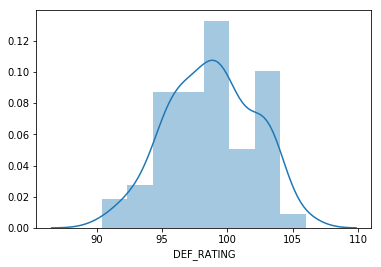

In [57]:
sns.distplot(First_Team_DEFR)

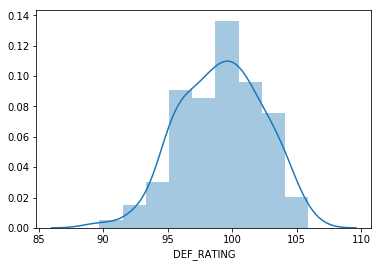

In [58]:
sns.distplot(Second_Team_DEFR)

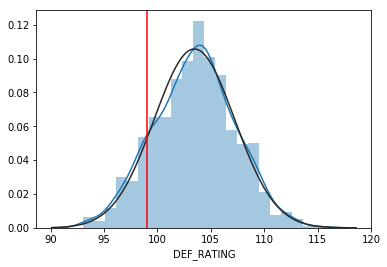

In [59]:
sns.distplot(Non_nominees_DEFR,fit = scipy.norm)
plt.axvline(x=99, color = "r")

__The mean for defensive rating for both teams is approximately 99.__

By approximating the distribution to a normal distribution for non_nominees, the probability that a non-nominee falls below 99 (1.2 standard deviations out) is approximately __12% of the time.__

This seems more reasonable, and aligns with what is commonly believed about defensive rating being a good metric for defense.

<br>
As seen, the defensive rating statistic tends to be inflated when not adjusted for minutes played.

A possible reason for that a __small sample size__, especially against poor competition may not be properly indicate a players defensive abilities.

Another possible reason is that Defensive Rating simply considers how many points per 100 possessions a player gives up. This __disregards the level of competition and help this player receives__

## Defensive Win Shares

The following is a link in how Defensive Win Shares are calculated:
https://www.basketball-reference.com/about/ws.html

One other statistic that is of interest is the Defensive Win Shares stat. Most nominations seem to be on average above the top 50, which suggests its a pretty good metric. 

There are, however, some anomalies. By looking at the boxplot below, its easy to see that although on average Defensive win share ranks of non-nominees are around 200, some players are ranked very high. Lets look at some specific example in order to explain why.

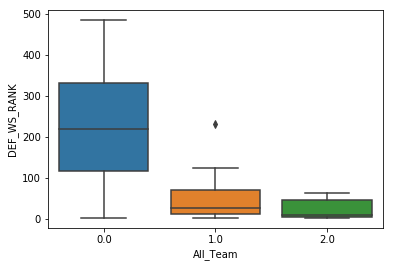

In [60]:
sns.boxplot(x = "All_Team", y = "DEF_WS_RANK", data = PG_Defense)

In [61]:
Non_nominees_DWS = Defense_General[Defense_General['All_Team'] == 0]
Non_nominees_DWS = Non_nominees_DWS.loc[:,['Player','DEF_WS_RANK','Year','DEF_WS','MIN','Pos','W_PCT']]
Non_nominees_DWS.sort_values(by = "DEF_WS_RANK", ascending = True).head(50)

,Player,DEF_WS_RANK,Year,DEF_WS,MIN,Pos,W_PCT
3886,Keon Clark,1.0,2003.0,0.086,14.0,PF,1.000
2631,Allen Iverson,1.0,2001.0,0.079,43.7,SG,0.600
5130,Pavel Podkolzin,1.0,2005.0,0.091,18.1,C,0.000
5678,Renaldo Major,1.0,2006.0,0.087,27.4,PF,0.000
7896,Luol Deng,1.0,2010.0,0.074,39.1,SF,0.756
20,Alonzo Mourning,1.0,1996.0,0.074,36.3,C,0.742
5662,Rafer Alston,2.0,2006.0,0.071,37.1,PG,0.634
4538,Metta World Peace,2.0,2004.0,0.072,41.4,SF,0.857
1621,Anfernee Hardaway,2.0,1999.0,0.074,37.5,SG,0.700
6224,Paul Pierce,2.0,2007.0,0.075,35.9,SF,0.800


It might actually be surprising to see some of these players like Tony Parker and Steph Curry featured on this top Defensive Win Shares list. 

However, this list does feature a lot of great defensive players like Shane Battier, David West(2013 season) and Metta World Peace.

The anomalies dont seem to be caused by a lack of minutes played like Defensive Rating, as most of the players shown here play 30+ minutes.

A possible reason for the anomalies is that although Defensive Win Shares does not technically have the team's record in the formula, the formula does contain a player's __Defensive Rating__ in it. As mentioned before, one of the faults with Defensive Rating is that it disregards the level of competition or help the player receives when he is on the floor.

In [62]:
First_Team_DWS = Defense_General[Defense_General['All_Team'] == 1]
First_Team_DWS = First_Team_DWS.loc[:,['Player','DEF_WS_RANK','Year','DEF_WS','MIN','Pos','W_PCT']]
First_Team_DWS.sort_values(by = "DEF_WS_RANK", ascending = False).head(30)

,Player,DEF_WS_RANK,Year,DEF_WS,MIN,Pos,W_PCT
1300,Gary Payton,231.0,1998.0,0.018,40.2,PG,0.500
2297,Gary Payton,125.0,2000.0,0.028,41.1,PG,0.544
8204,Chris Paul,109.0,2011.0,0.032,36.3,PG,0.617
5559,Kobe Bryant,108.0,2006.0,0.031,40.8,SG,0.506
9203,Tyson Chandler,96.0,2012.0,0.032,32.8,C,0.636
11415,Patrick Beverley,95.0,2016.0,0.032,30.7,SG,0.687
8743,Chris Paul,85.0,2012.0,0.033,33.4,PG,0.714
4465,Kevin Garnett,80.0,2004.0,0.035,38.1,PF,0.537
2798,Gary Payton,73.0,2001.0,0.035,40.2,PG,0.549
9954,DeAndre Jordan,72.0,2014.0,0.035,34.4,C,0.683


Conversely, its curious to see the players with great defensive reputation to have ranked so lowly on Defensive Win Shares. Players include Kobe Bryant and Gary Payton.

When comparing the 2 players mentioned from both tables:

>From the Non-Nominees, Steph Curry(0.06 DWS) had a W/L% of __0.0899__ in 2015, while Tony Parker(0.066 DWS) had a W/L% of __0.763__ in 2005.

>From the First Team, Kobe Bryant(0.031 DWS) had a W/L% of __0.0506__ in 2006, while Gary Payton(0.018 DWS) had a W/L% of __0.5__ in 1998

Another thing to notice is that these players seem mostly to be players to be guards, suggesting that Defensive Win Shares may not be the best indicator for good Guard defenders. A Bar Plot is created to show this.

<br>
Because there is a correlation between W/L% and DWS/Defense Rating, __W/L%__ may in turn naturally seem like a good indicator for nominations

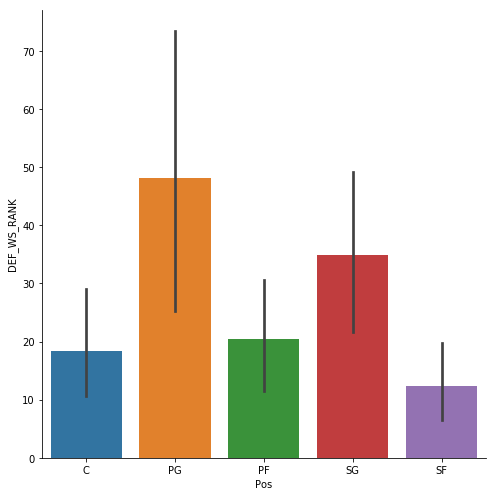

In [63]:
sns.factorplot(x = "Pos", y = 'DEF_WS_RANK', data = First_Team_DWS, kind = 'bar',size =7)

From this simple bar chart, it can be seen that elite defenisve guards rank more poorly compared to elite defensive bigs. 

A possible explanation for this is the importance of an anchoring defensive center to a good defense.


To get a more statistical view of this phenomenon, lets plot out the histograms for the various teams. To avoid __negative ranks__ being plotted on the histogram, the __raw Defensive Win Shares__ will be used instead.

In [64]:
First_Team_DWS = Defense_General['DEF_WS'][Defense_General['All_Team']==1]
Second_Team_DWS = Defense_General['DEF_WS'][Defense_General['All_Team']==2]
Non_nominees_DWS = Defense_General['DEF_WS'][Defense_General['All_Team']==0]

In [65]:
SD_and_Mean = DataFrame(data = [First_Team_DWS.std(),Second_Team_DWS.std(),Non_nominees_DWS.std()]
                               ,columns = ["S.D"])
SD_and_Mean['All_Team'] = list([1,2,3])
SD_and_Mean['Mean'] = list([First_Team_DWS.mean(),Second_Team_DWS.mean(),Non_nominees_DWS.mean()])
SD_and_Mean

,S.D,All_Team,Mean
0,0.013048,1,0.055161
1,0.011852,2,0.051364
2,0.014484,3,0.019441


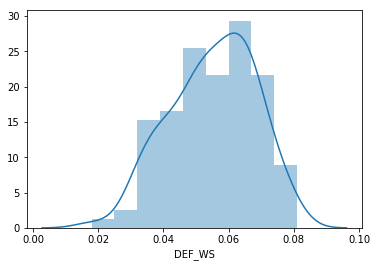

In [66]:
sns.distplot(First_Team_DWS)

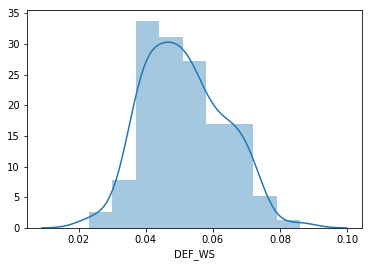

In [67]:
sns.distplot(Second_Team_DWS)

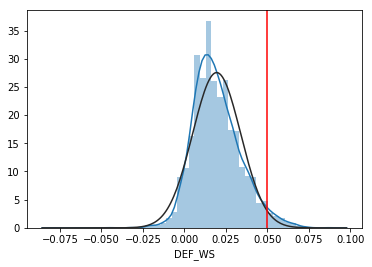

In [68]:
sns.distplot(Non_nominees_DWS,fit = scipy.norm)
plt.axvline(x=0.05, color = "r")

The mean for both teams is approximately __0.05 Defensive Win Shares__.

By approximating the distribution to a __normal distribution__ for non_nominees, the probability that a non-nominee falls above 0.05 (2.1 standard deviations out) is approximately __2% of the time.__

These non-nominated players may be solid or even good defensive players, but may have just missed the cut because media decision.

## A look at the distribution of minutes and DWS/DEFR

In [69]:
DEFR_MIN_First_Team = Defense_General [["DEF_RATING_RANK","MIN"]][Defense_General["All_Team"]==1]
DEFR_MIN_Second_Team = Defense_General [["DEF_RATING_RANK","MIN"]][Defense_General["All_Team"]==2]
DEFR_MIN_Non_Nominees = Defense_General [["DEF_RATING_RANK","MIN"]][Defense_General["All_Team"]==0]

In [70]:
DWS_MIN_First_Team = Defense_General [["DEF_WS","MIN"]][Defense_General["All_Team"]==1]
DWS_MIN_Second_Team = Defense_General [["DEF_WS","MIN"]][Defense_General["All_Team"]==2]
DWS_MIN_Non_Nominees = Defense_General [["DEF_WS","MIN"]][Defense_General["All_Team"]==0]

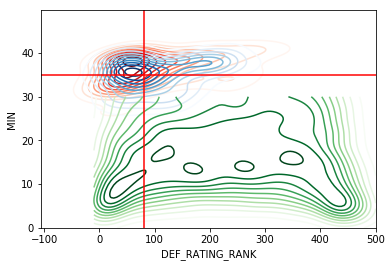

In [71]:
ax = sns.kdeplot(DEFR_MIN_First_Team.DEF_RATING_RANK, DEFR_MIN_First_Team.MIN, cmap="Reds", shade_lowest=False)
ax = sns.kdeplot(DEFR_MIN_Second_Team.DEF_RATING_RANK, DEFR_MIN_Second_Team.MIN, cmap="Blues",shade_lowest=False)
ax = sns.kdeplot(DEFR_MIN_Non_Nominees.DEF_RATING_RANK, DEFR_MIN_Non_Nominees.MIN, cmap="Greens", shade_lowest=False,clip = ((-10,500),(0,30)))
plt.axvline(x=80,color ="r")
plt.axhline(y=35,color ="r")

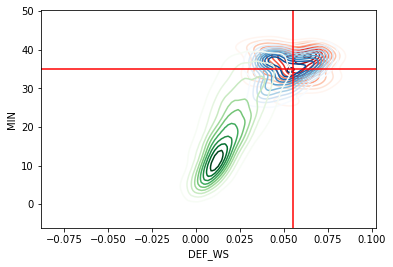

In [72]:
ax = sns.kdeplot(DWS_MIN_First_Team.DEF_WS, DWS_MIN_First_Team.MIN, cmap="Reds", shade_lowest=False)
ax = sns.kdeplot(DWS_MIN_Second_Team.DEF_WS, DWS_MIN_Second_Team.MIN, cmap="Blues",shade_lowest=False)
ax = sns.kdeplot(DWS_MIN_Non_Nominees.DEF_WS, DWS_MIN_Non_Nominees.MIN, cmap="Greens", shade_lowest=False)
plt.axvline(x=0.055,color ="r")
plt.axhline(y=35,color ="r")

From both of these diagrams, there seem to be a clustering of First and Second Team players compared to the rest of the players.

<br>
Let's use Bayes Theorem to investigate the probability a player gets on either team given any 2 of these 3 statistics.

From the clusters, some values are picked close to the distributions of All-Defensive teams to investigate the probability:

1) Given that the player is plays over 35 minutes and has a DWS over 0.055, what is the probability he will be on either First or Second Team?

2) Given that the player is plays over 35 minutes and has a Defensive Rating Rank less than 80, what is the probability he will be on either First or Second Team?

In [73]:
len(Defense_General[(Defense_General['MIN'] > 35) & (Defense_General["DEF_WS"] > 0.055)])

152

In [74]:
len(DWS_MIN_First_Team[(DWS_MIN_First_Team['MIN']>35) & (DWS_MIN_First_Team["DEF_WS"]>0.055)])

38

In [75]:
len(DWS_MIN_Second_Team[(DWS_MIN_Second_Team['MIN']>35) & (DWS_MIN_Second_Team["DEF_WS"]>0.055)])

25

In [76]:
len(Defense_General[(Defense_General['MIN']>35) & (Defense_General["DEF_RATING_RANK"]<80)])

131

In [77]:
len(DEFR_MIN_First_Team[(DEFR_MIN_First_Team['MIN']>35) & (DEFR_MIN_First_Team["DEF_RATING_RANK"]<80)])

35

In [78]:
len(DEFR_MIN_Second_Team[(DEFR_MIN_Second_Team['MIN']>35) & (DEFR_MIN_Second_Team["DEF_RATING_RANK"]<80)])

25

In [79]:
len(Defense_General)

11556

1) Given that the player is plays over 35 minutes and has a DWS over 0.055, what is the probability he will be on either First or Second Team?

>First Team: (38/11556)/(152/11556) = 25%

>Second Team: (25/11556)/(152/11556) = 16%

2) Given that the player is plays over 35 minutes and has a Defensive Rating Rank less than 80, what is the probability he will be on either First or Second Team?
>First Team: (35/11556)/(131/11556) = 26%

>Second Team: (25/11556)/(131/1156) = 20%

It appears that even if a player gets very close to the averages for all defensive teams, the probability of getting into the teams are quite slim.

This probably speaks to the fact some aspects of defense is intangible and not measurable by numbers. Also, media members may be biased towards big name stars with good reputation.

## Analysis of Opponent Shooting Statistics

Let's look at shooting stats now. It seems that field goal percentage is not directly related to defensive team nominations.

Two transformations will be done to try to better analyze these metrics:

>1) Sort into position

>2) Create per minute metrics 

>3) Filter by players who have played above a certain threshold of minutes

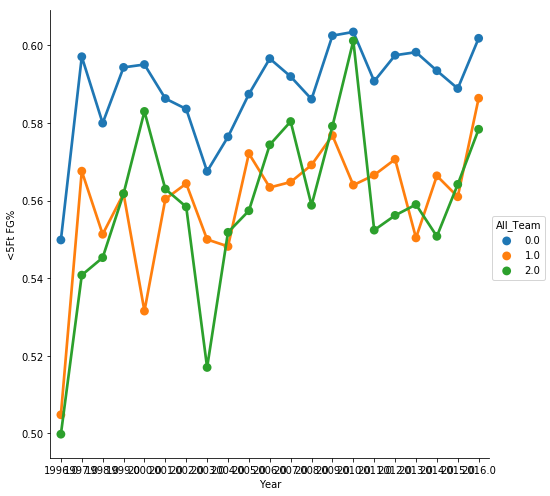

In [80]:
sns.factorplot(x="Year",y="<5Ft FG%",data = Shooting,hue="All_Team",ci=0,size=7)

In [81]:
Shooting = Shooting[Shooting['MIN']>35]

In [82]:
Shooting['<5Ft FGM/Min'] = Shooting['<5Ft FGM']/Shooting['MIN']
Shooting['<5Ft FGA/Min'] = Shooting['<5Ft FGA']/Shooting['MIN']
Shooting['<5Ft FG%/Min'] = Shooting['<5Ft FG%']/Shooting['MIN']
Shooting['5-9 Ft FGM/Min'] = Shooting['5-9 Ft FGM']/Shooting['MIN'] 
Shooting['5-9 Ft FGA/Min'] = Shooting['5-9 Ft FGA']/Shooting['MIN'] 
Shooting['5-9 Ft FG%/Min'] = Shooting['5-9 Ft FG%']/Shooting['MIN'] 
Shooting['10-14 Ft FGM/Min'] = Shooting['10-14 Ft FGM']/Shooting['MIN'] 
Shooting['10-14 Ft FGA/Min'] = Shooting['10-14 Ft FGA']/Shooting['MIN']  
Shooting['10-14 Ft FG%/Min'] = Shooting['10-14 Ft FG%']/Shooting['MIN'] 
Shooting['15-19 Ft FGM/Min'] = Shooting['15-19 Ft FGM']/Shooting['MIN'] 
Shooting['15-19 Ft FGA/Min'] = Shooting['15-19 Ft FGA']/Shooting['MIN'] 
Shooting['15-19 Ft FG%/Min'] = Shooting['15-19 Ft FG%']/Shooting['MIN'] 
Shooting['20-24 Ft FGM/Min'] = Shooting['20-24 Ft FGM']/Shooting['MIN'] 
Shooting['20-24 Ft FGA/Min'] = Shooting['20-24 Ft FGA']/Shooting['MIN'] 
Shooting['20-24 Ft FG%/Min'] = Shooting['20-24 Ft FG%']/Shooting['MIN'] 
Shooting['25-29 Ft FGM/Min'] = Shooting['25-29 Ft FGM']/Shooting['MIN'] 
Shooting['25-29 Ft FGA/Min'] = Shooting['25-29 Ft FGA']/Shooting['MIN'] 
Shooting['25-29 Ft FG%/Min'] = Shooting['25-29 Ft FG%']/Shooting['MIN'] 

In [83]:
PG_Shooting = Shooting[Shooting['Pos'].str.contains("PG")]
SG_Shooting = Shooting[Shooting['Pos'].str.contains("SG")]
SF_Shooting = Shooting[Shooting['Pos'].str.contains("SF")]
PF_Shooting = Shooting[Shooting['Pos'].str.contains("PF")]
C_Shooting = Shooting[Shooting['Pos'].str.contains("C")]

By graphing various combinations of positions, counter (made, attempted and percentage) and shooting ranges, not many patterns show up except one.

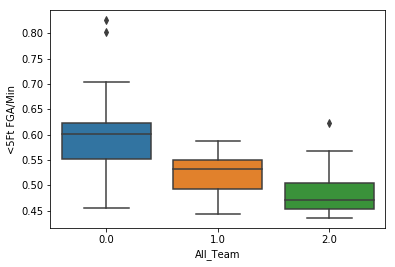

In [84]:
sns.boxplot(x="All_Team",y="<5Ft FGA/Min",data = C_Shooting)

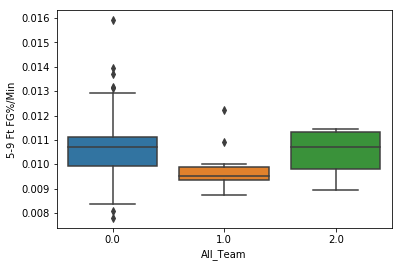

In [85]:
sns.boxplot(x="All_Team",y="5-9 Ft FG%/Min",data = PF_Shooting)

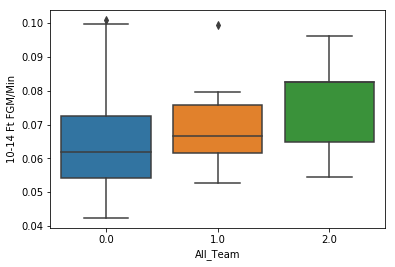

In [86]:
sns.boxplot(x="All_Team",y="10-14 Ft FGM/Min",data = SG_Shooting)

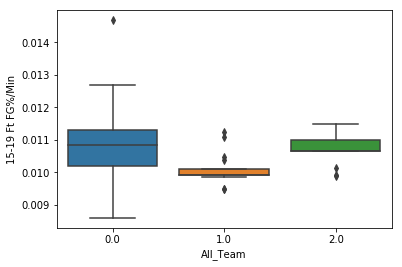

In [87]:
sns.boxplot(x="All_Team",y="15-19 Ft FG%/Min",data = SF_Shooting)

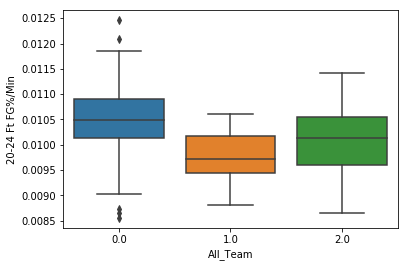

In [88]:
sns.boxplot(x="All_Team",y="20-24 Ft FG%/Min",data = PG_Shooting)

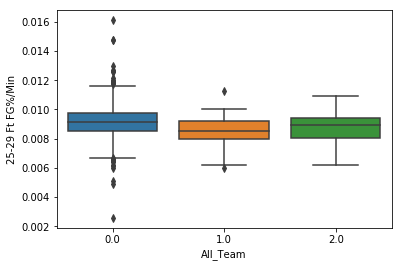

In [89]:
sns.boxplot(x="All_Team",y="25-29 Ft FG%/Min",data = Shooting)

In [90]:
C_Shooting[["<5Ft FGA/Min","Player","Year"]].sort_values(by = "<5Ft FGA/Min", ascending = True).head(6)

,<5Ft FGA/Min,Player,Year
4197,0.435262,Dikembe Mutombo,2001.0
12202,0.444149,Dwight Howard,2010.0
3915,0.448101,Shaquille O'Neal,2000.0
3117,0.453865,Shaquille O'Neal,1999.0
4586,0.454294,Shaquille O'Neal,2001.0
5250,0.457672,Shaquille O'Neal,2002.0


The one graph that stands out is the __FGA/MIN for Centers__. Lets look more closely at the distributions for centers.  

A possible explanation for this difference in non-nominated centers compared to defensive team centers is a psychological fear or intimidation of opposing players when attacking the paint.

Looking down the list of all defensive centers, it contains notable defensive powerhouses the likes of __Shaq, Dikembe Mutombo, Dwight Howard and Tyson Chandler__

While these players are not necessarily the best defensive centers (Shaq 02' season as an example allowed 0.45 FGA/Min, which is good for top 6 all time for centers),they may simply intimidate their opponents to take more difficult shots.

 ## Conclusion

The following features are seen to have __high correlation with nomination (ignoring position)__:


>1) Minutes: Players who play more minutes get recognized more and play more difficult competition

>2) Defensive Win Shares: Although there are anomalies, the average of non nominees and nominees are quite significant.

>3) Defensive Rating (adjusted for minute): Defensive Rating can somewhat measure more intangible aspects of defense like communication or good switching.

>4) Wins (or Wins percentage): Players on better teams tend to get more shine from the media

>5) Defensive Rebounds: Good defensive rebounders can prevent second chance opportunities and can trigger fast breaks.

The following features are seen to have __high correlation with nomination for Guards__:


>1) Steals: Steals may often result in exciting plays, and are in general a good tell of court awareness and activity. i.e Chris Paul


The following features are seen to have __high correlation with nominations of Bigs__:


>1) Blocks: Blocks are sometimes highlight plays and is an "intimidation factor" for opposing offenses i.e Rudy Gobert

>2) <5 ft FGA (for centers)